In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pyhsmm
import pyhsmm.basic.distributions as distributions
import pandas as pd

In [8]:
filepath = "/media/sf_VBox_Shared/London/example_data"
filename = filepath + '/example_bobby_feature5min.csv'
data_10min = pd.read_csv(filename)
data_10min.head()

,time,id,serial number,filename,Nhoursvalid,mean metric ENMO,sd metric ENMO,p5 metric ENMO,p25 metric ENMO,p50 metric ENMO,p75 metric ENMO,p95 metric ENMO,mean metric anglez,sd metric anglez,p5 metric anglez,p25 metric anglez,p50 metric anglez,p75 metric anglez,p95 metric anglez,day
0,2014-08-01 04:00:00,not stored in header,16563,__016563_2014-08-08 12-02-19.bin,0.166667,0.015216,0.000530,0.014479,0.014857,0.015209,0.015546,0.016095,-39.317284,0.048373,-39.378809,-39.352864,-39.316961,-39.281406,-39.240260,2014-08-01
1,2014-08-01 04:10:00,not stored in header,16563,__016563_2014-08-08 12-02-19.bin,0.166667,0.015160,0.000522,0.014232,0.014874,0.015133,0.015534,0.015891,-39.349687,0.065171,-39.452094,-39.391423,-39.336663,-39.307390,-39.264456,2014-08-01
2,2014-08-01 04:20:00,not stored in header,16563,__016563_2014-08-08 12-02-19.bin,0.166667,0.015181,0.004180,0.010862,0.014729,0.015099,0.015506,0.016189,-37.359455,7.890470,-39.431267,-39.364191,-39.337401,-39.299842,-26.144194,2014-08-01
3,2014-08-01 04:30:00,not stored in header,16563,__016563_2014-08-08 12-02-19.bin,0.166667,0.015197,0.008969,0.011073,0.011628,0.012248,0.012886,0.025105,-36.171533,5.857137,-48.853285,-34.069524,-33.879162,-32.846824,-32.753698,2014-08-01
4,2014-08-01 04:40:00,not stored in header,16563,__016563_2014-08-08 12-02-19.bin,0.166667,0.015590,0.020108,0.000000,0.000000,0.000000,0.025809,0.040461,5.806129,54.439121,-59.597338,-46.786000,55.306174,55.474992,60.089516,2014-08-01


In [10]:
data_10min = data_10min.set_index('time')
data_10min.index = pd.to_datetime(data_10min.index)
print(min(data_10min.index))
print(max(data_10min.index))

2014-08-01 04:00:00
2014-08-01 23:50:00


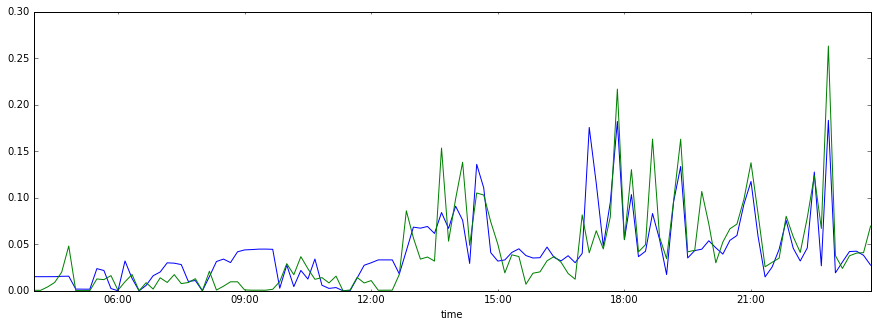

In [25]:
plt.subplots(figsize=(15,5))
data_10min["mean metric ENMO"].plot()
data_10min["sd metric ENMO"].plot();

In [26]:
X = np.column_stack([data_10min["mean metric ENMO"], data_10min["sd metric ENMO"]])
#column_names = day1_5sec.columns[0:4]
#print(column_names)
#X = np.array(data_10min["mean metric ENMO"])[:, np.newaxis]
print(X.shape)

(120, 2)


In [37]:
#Parameters for HSMM
Nmax = 5
affine = True
dim = X.shape[1]

In [61]:
#Observations are gaussians
obs_hypparams = {'mu_0': np.zeros(dim), #prior mean of gaussians
                'sigma_0': np.eye(dim), #prior cov matrix of gaussians
                 'kappa_0': 0.3, #mean was estimated from kappa_0 observation
                 'nu_0': dim+5 #covariance was estimated from nu_0 observation
                }

#duration is going to be poisson, so prior is a gamma distribution (params alpha betta)
# alpha occurences in beta intervals
expected_duration = 6 # one hour
dur_hypparams = {'alpha_0': 2*expected_duration,
                'beta_0': 2}

In [62]:
obs_distns = [distributions.Gaussian(**obs_hypparams) for state in range(Nmax)]
dur_distns = [distributions.PoissonDuration(**dur_hypparams) for state in range(Nmax)]


In [63]:
model = pyhsmm.models.WeakLimitHDPHSMM(
        alpha_a_0=1.,alpha_b_0=1./4,
        gamma_a_0=1.,gamma_b_0=1./4,
        init_state_concentration=6., 
        obs_distns=obs_distns,
        dur_distns=dur_distns)

In [64]:
model.add_data(X, trunc=60)

In [42]:
model.resample_model()

In [65]:
#resample
import copy
models = []
for idx in xrange(100):
    model.resample_model()
    if (idx+1) % 10 == 0:
        print(idx)
        models.append(copy.deepcopy(model))

9
19
29
39
49
59
69
79
89
99


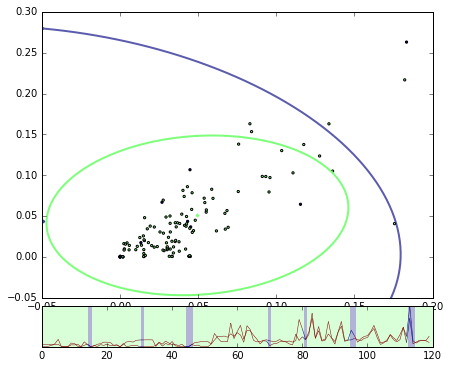

In [66]:
#model.stateseqs
plots = model.plot(draw=False)
#plt.savefig('model')
#plots

In [67]:
for d in model.obs_distns:
    print(d.mu)
  
print('')
for d in model.obs_distns:
    print(d.sigma)
print('')
for d in model.dur_distns:
    print d.lmbda
    
    

[ 0.04952152  0.05096761]
[ 0.19831332 -0.55359408]
[-0.56255044  0.30757514]
[-0.04928707  0.04368056]
[-0.17148979  0.49996869]

[[ 0.00933515  0.00092152]
 [ 0.00092152  0.00956606]]
[[ 0.1842783  -0.09996158]
 [-0.09996158  0.24357614]]
[[ 0.14938511 -0.0283432 ]
 [-0.0283432   0.29412122]]
[[ 0.05238697 -0.00926539]
 [-0.00926539  0.05737768]]
[[ 0.23821632 -0.09902908]
 [-0.09902908  0.23480771]]

11.5615484314
3.65705049761
3.04644937015
1.83049210488
8.90022107931


In [68]:
model.stateseqs[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0,
       0, 0, 0, 0, 0], dtype=int32)

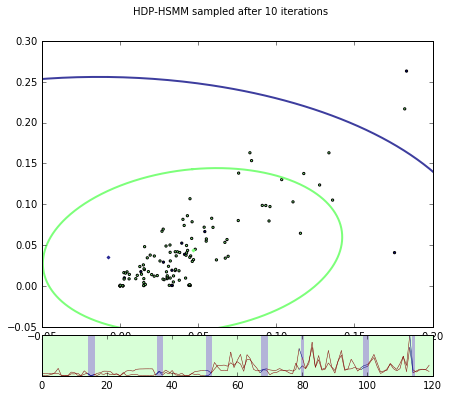

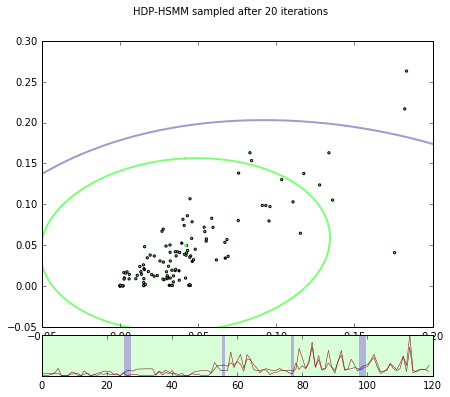

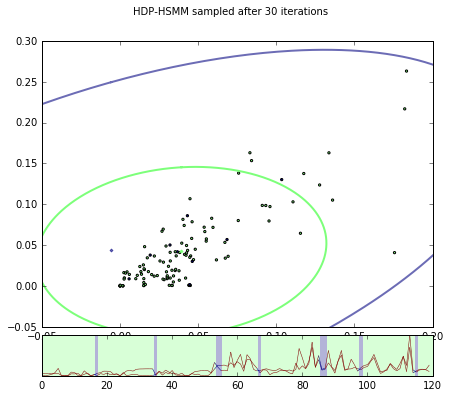

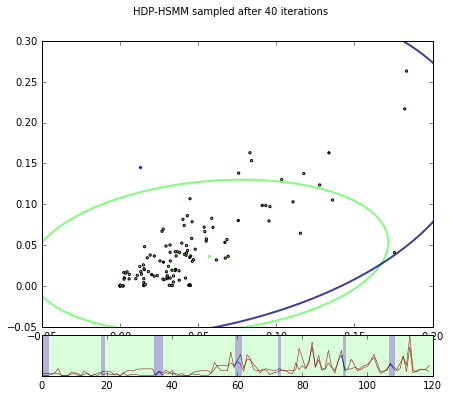

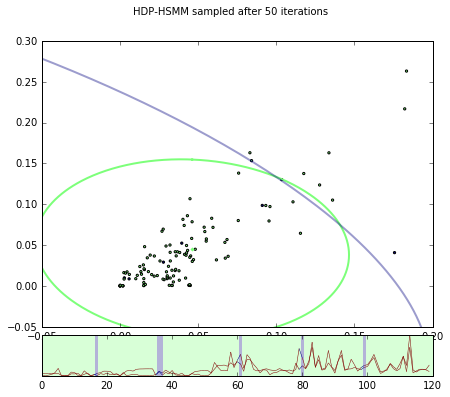

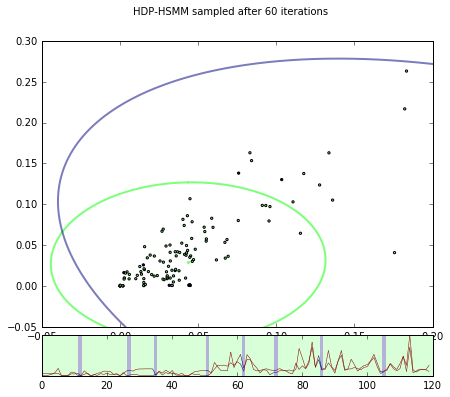

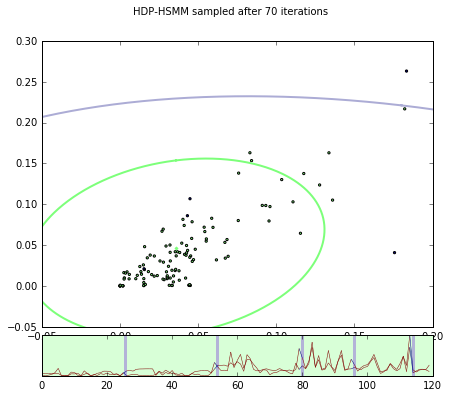

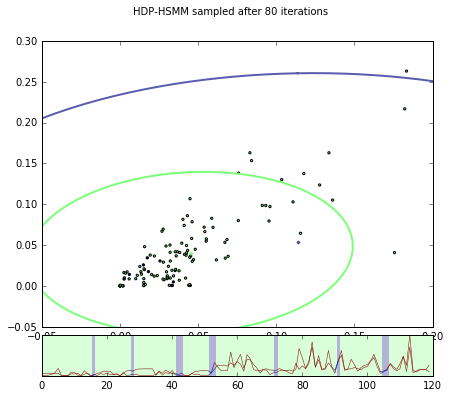

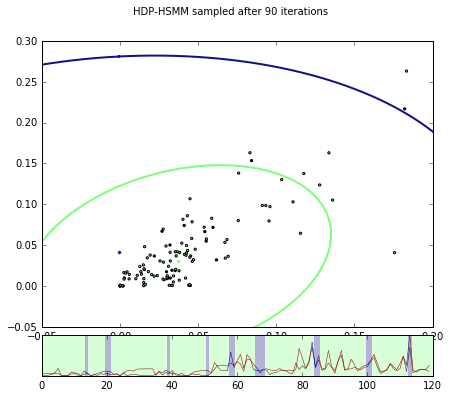

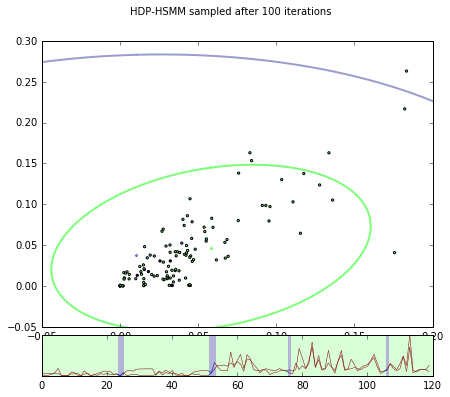

In [54]:
import time
fig = plt.figure(figsize = (15, 15))
for idx, mod in enumerate(models):
    plt.clf()
    mod.plot()
    plt.gcf().suptitle('HDP-HSMM sampled after %d iterations' % (10*(idx+1)))
    plt.show()
    #time.sleep(0.5)
    #plt.savefig('iter_%.3d.png' % (10*(idx+1)))

In [80]:
mask = model.stateseqs[0] != i
data_to_plot.

TypeError: 'instancemethod' object does not support item assignment

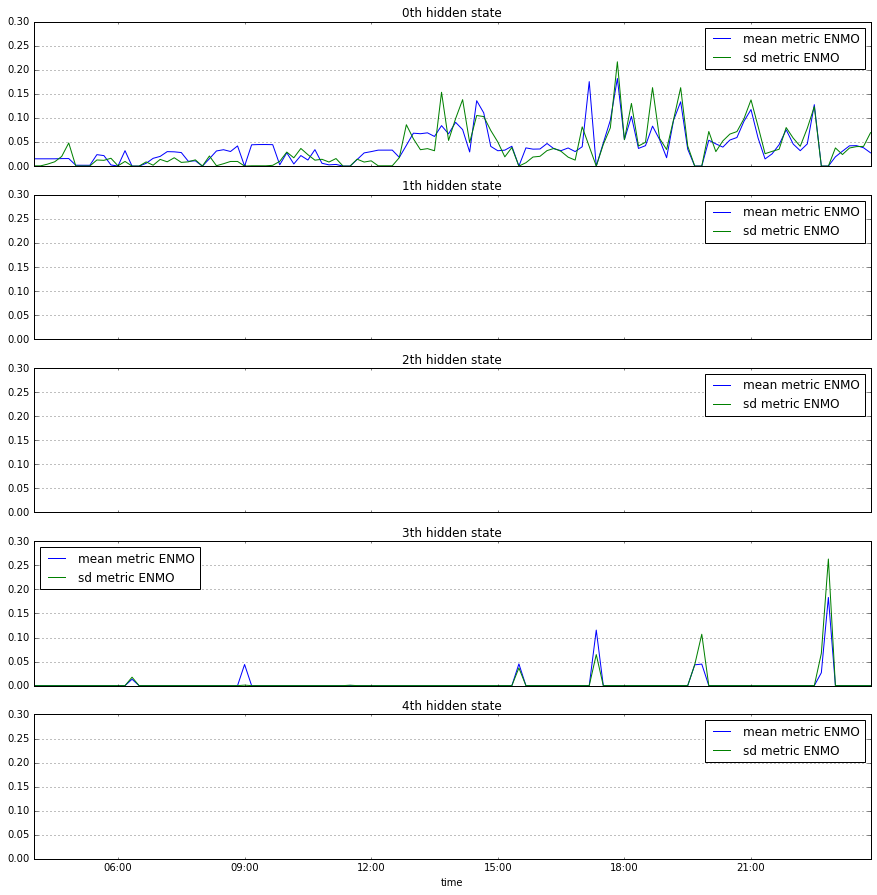

In [81]:
fig, axs = plt.subplots(model.num_states, sharex=True, sharey=True, figsize=(15,15))
colours = cm.rainbow(np.linspace(0, 1, model.num_states))
for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    data_to_plot = data.copy()
    data_to_plot[model.stateseqs[0] != i] = 0
    data_to_plot.plot(ax=ax)
    #ax.plot(plotdata, ".-")
    ax.set_title("{0}th hidden state".format(i))

    # Format the ticks.
    #ax.xaxis.set_major_locator(YearLocator())
    #ax.xaxis.set_minor_locator(MonthLocator())

    ax.grid(True)

plt.show()

In [ ]:
fig = figure(figsize=(15,5))
byAct = day1_5sec.groupby('Activity')
fig, ax = plt.subplots(figsize=(15,5))
for act,dfa in byAct:
    dfa['acceleration'].plot(label=act)
legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3);
colormap = {0: (1,1,0), 1: (1,0,0), 2: (0,1,0), 3: (0,0,1)}
state_colors = [colormap[i] for i in hidden_states]
plt.scatter(day1_5sec.index, np.ones_like(hidden_states), color=state_colors)
#plt.xlim(min(), max(byAct.index))

In [ ]:
model.transmat_

In [ ]:
plotdata = model.means_

fig, ax = plt.subplots()
colorplot = ax.pcolor(plotdata, cmap='coolwarm',)
ax.set_xticks(np.arange(plotdata.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(plotdata.shape[0])+0.5, minor=False)
ax.set_xticklabels(column_names, minor=False)
ax.set_yticklabels(range(plotdata.shape[0]), minor=False)
plt.colorbar(colorplot)

In [ ]:
plotdata = model.means_[:,0][:,np.newaxis]
grouplabels = ["{:.3}".format(x) for x in plotdata[:,0]]
fig, ax = plt.subplots()
colorplot = ax.pcolor(plotdata, cmap='coolwarm',)
ax.set_xticks(np.arange(plotdata.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(plotdata.shape[0])+0.5, minor=False)
ax.set_xticklabels(column_names, minor=False)
ax.set_yticklabels(grouplabels, minor=False)
fig.colorbar(colorplot)
print()

In [ ]:
fig, axs = plt.subplots(nrows=model.n_components, ncols=1,  figsize = (10, 15))
for i in range(nr_states):
    im = axs[i].pcolor(model.covars_[i], cmap='coolwarm',)
    fig.colorbar(im, ax = axs[i], extend='max')
#colorbar()
show()

In [ ]:
from scipy.stats.kde import gaussian_kde

variable = "acceleration"

fig, ax = subplots()
#day1_5sec.hist(variable, bins=100)
vals = day1_5sec[variable]
kde = gaussian_kde(vals)
d = np.linspace(min(vals), max(vals), 100)
p = plot(d, kde(d), label="all")

for i in range(nr_states):
    mask = hidden_states == i
    kde = gaussian_kde(vals[mask])
    plot(d, kde(d), label=str(i))
    #p = plt.hist(day1_5sec[mask][variable], bins=100)
ax.set_xlim(0,0.1)
legend()
show()

In [ ]:
column_names